In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('pjme_hourly.csv')
# set our dataframe to datetime
df = df.set_index('Datetime')
# to cast the object of our dataframe as a datetime
df.index = pd.to_datetime(df.index)

In [3]:
df.head(3)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0


In [4]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


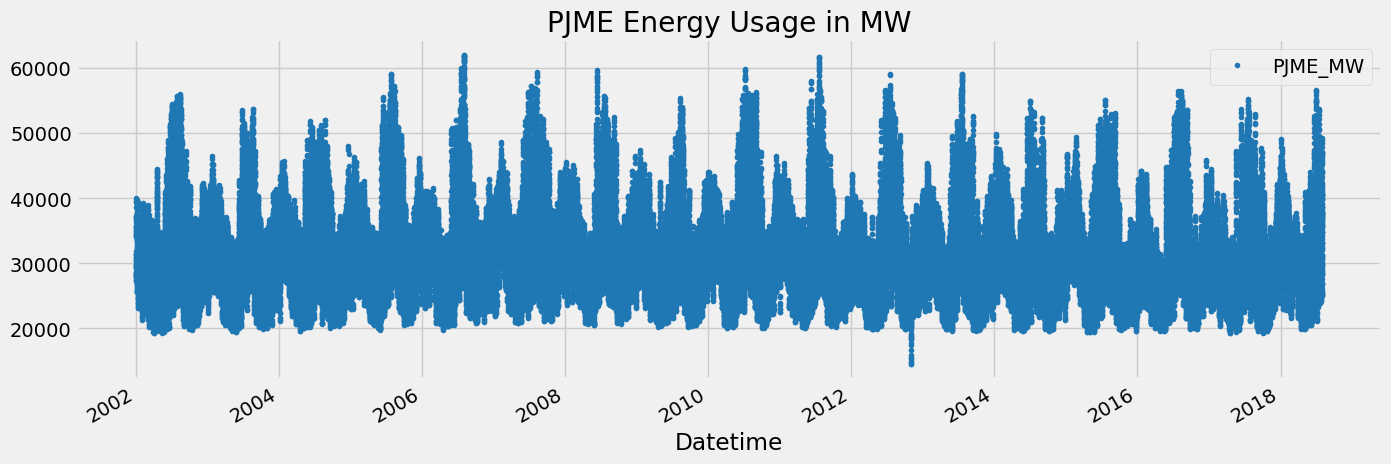

In [5]:
df.plot(style=".", figsize=(15, 5), color=color_pal[0], title="PJME Energy Usage in MW")

plt.show()


### Outlier Analysis and Removal

<Axes: ylabel='Frequency'>

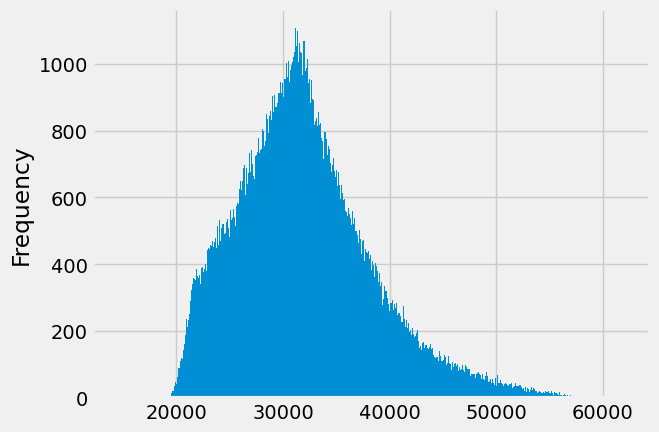

In [6]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: xlabel='Datetime'>

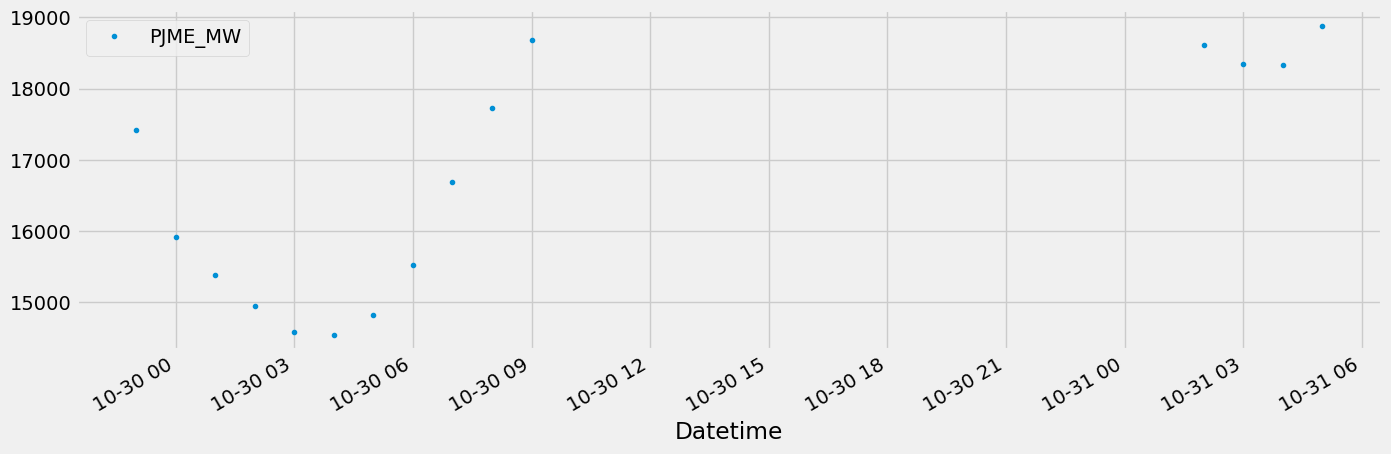

In [7]:
df.query('PJME_MW < 19000').plot(figsize=(15, 5), style='.')

In [8]:
df = df.query('PJME_MW > 19000').copy()

### Train/test Split

In [9]:
# Our training dataset will be from january 2012 to december 2014
# our test dataset will be from january 2015
train = df.loc[df.index < '01-02-2015']
test = df.loc[df.index >= '01-02-2015']

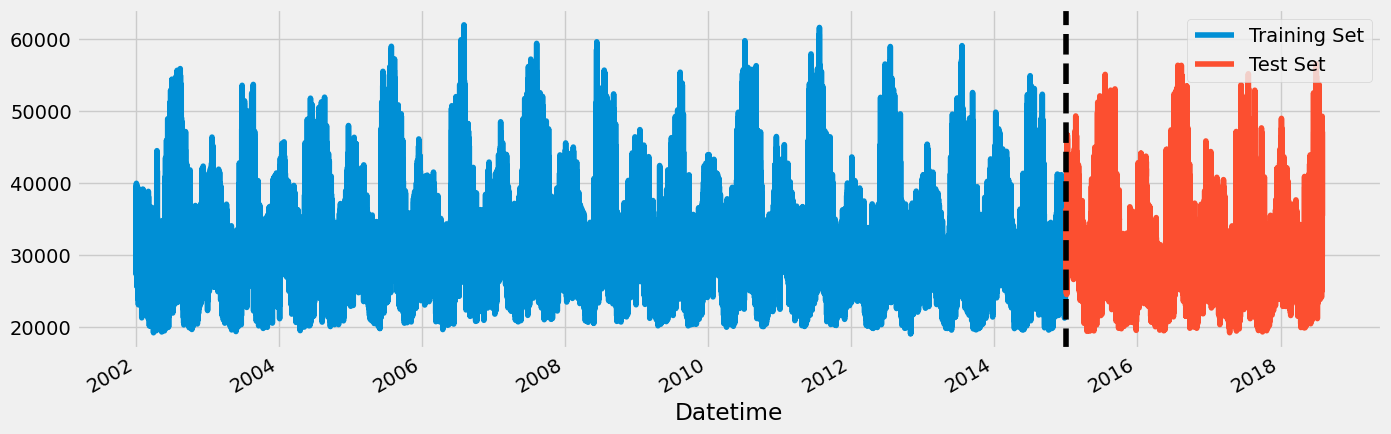

In [10]:
#plotting both test and training dataset
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls= '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Time Series Cross Validation

In [11]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

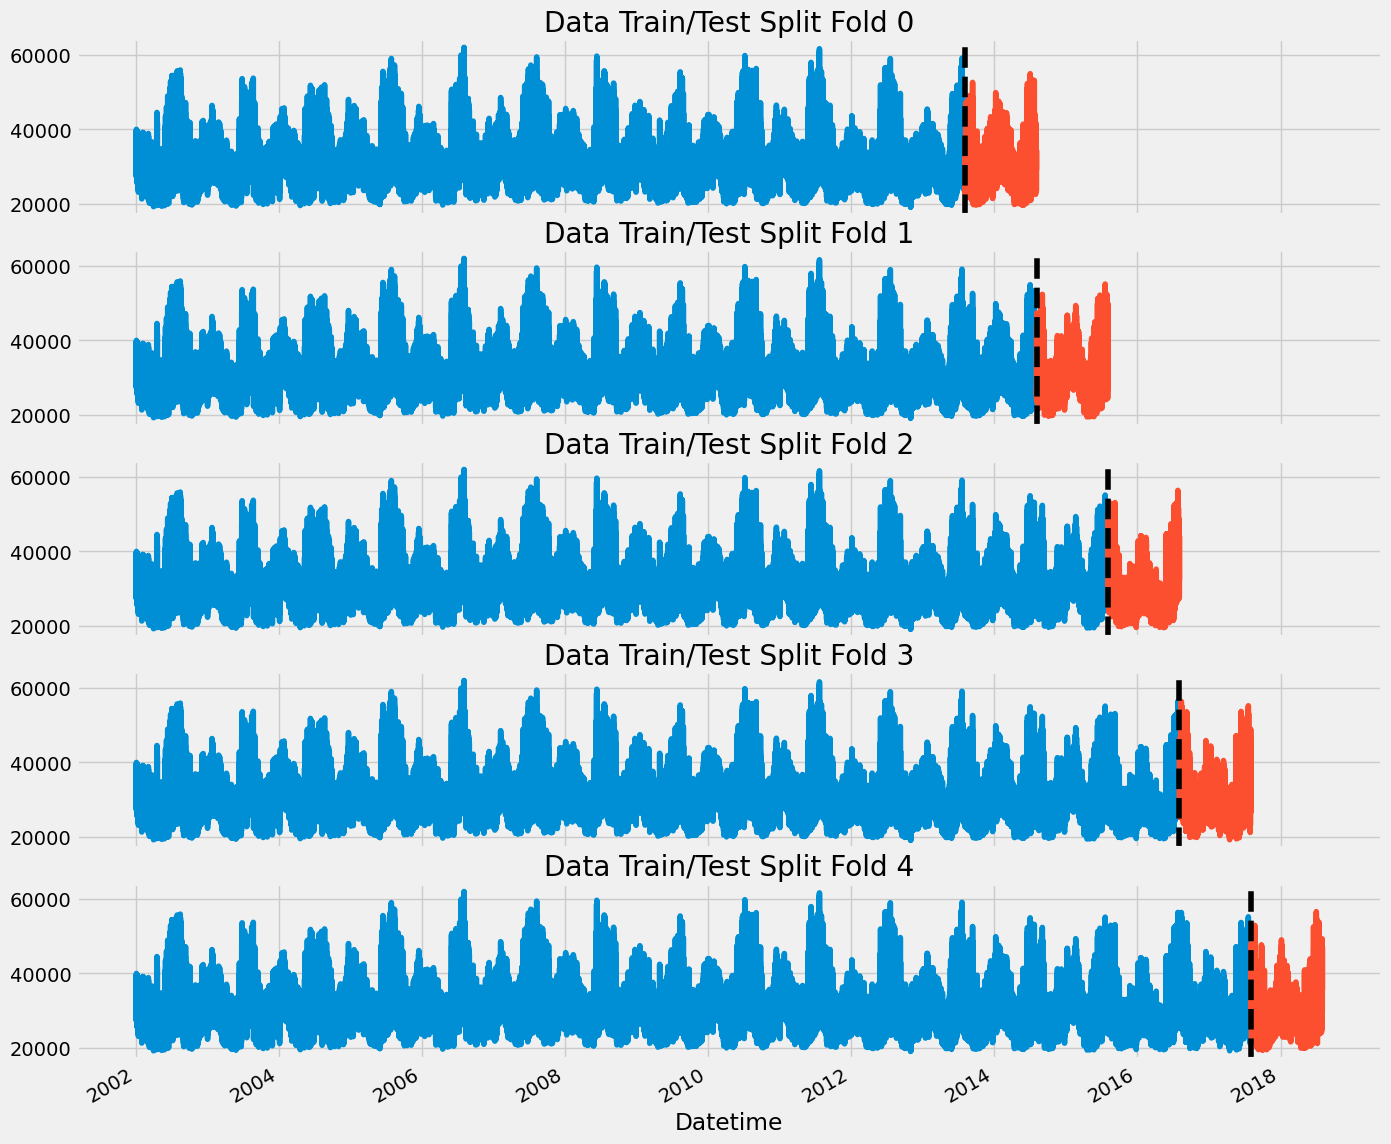

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Forcasting Horizon explained
- The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

### Feature Engineering

In [13]:
def create_features(df):
    '''Create features 
      datetime column'''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    return df



In [14]:
df = create_features(df)

### Lag Features
- What was the target (x) days in the past?

In [15]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [16]:
df = add_lags(df)

In [ ]:
# Our training dataset will be from january 2012 to december 2014
# our test dataset will be from january 2015

train = df.loc[df.index < '01-02-2015']
test = df.loc[df.index >= '01-02-2015']


### Train Using Cross Validation

In [19]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[10:08:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[457]	validation_0-rmse:3348.29869	validation_1-rmse:3761.08467
[10:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rms

In [20]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3750.6406
Fold scores:[3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.3608331481823, 3996.298054855067]


### Feature importance

In [21]:
reg.feature_importances_

array([0.03752635, 0.07088066, 0.02621353, 0.        , 0.05519564,
       0.02148012, 0.4482099 , 0.22820628, 0.11228751], dtype=float32)

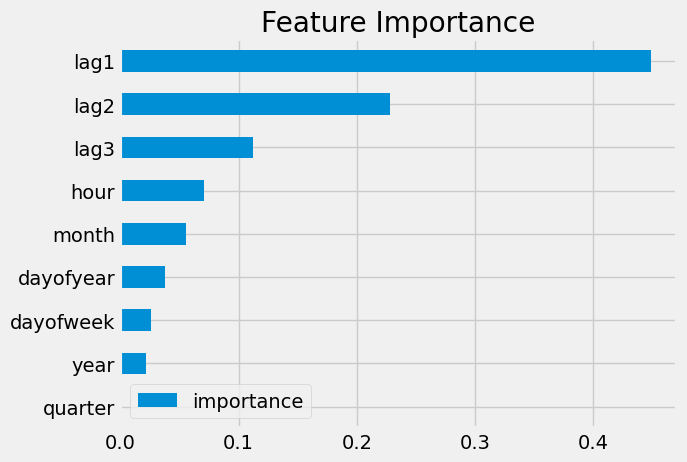

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forcast on Test

In [23]:
test['prediction'] = reg.predict(X_test)

In [24]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df.head()

,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear,weekofyear,lag1,lag2,lag3,prediction
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,NaN,NaN,NaN,NaN


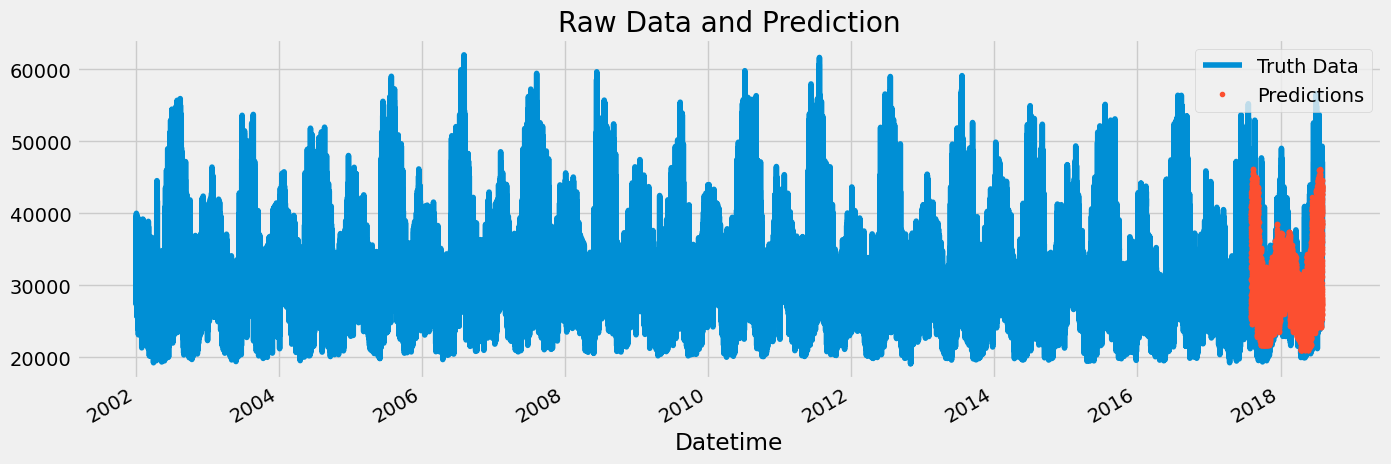

In [25]:

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

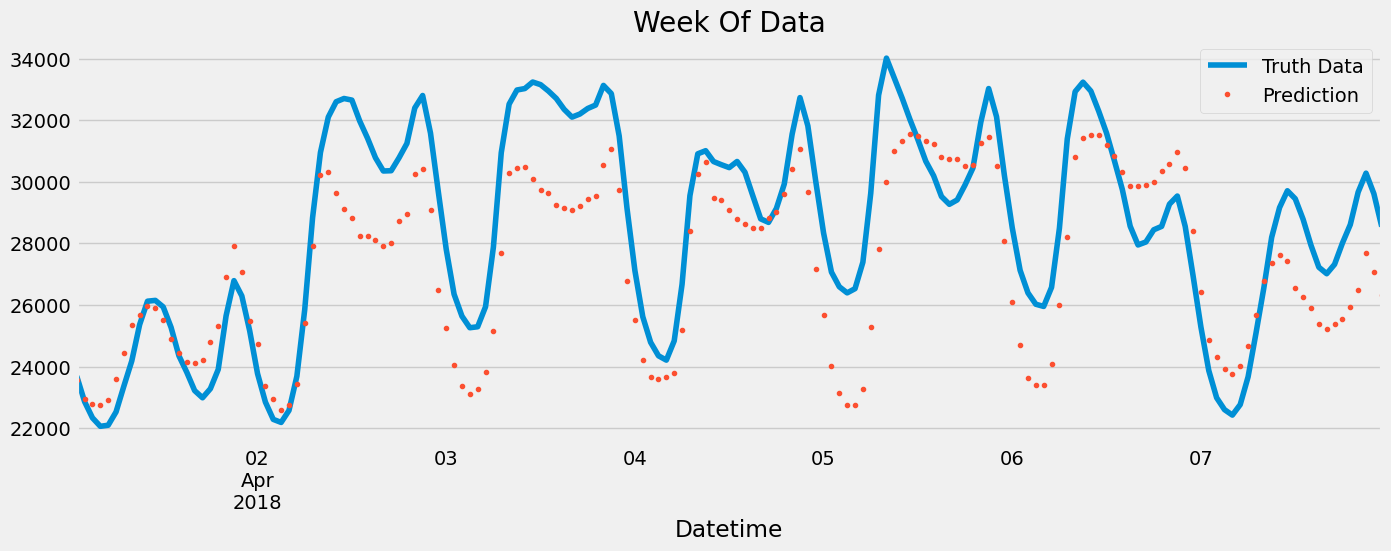

In [26]:
#plotting the predictions over 1 week
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [27]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3996.30


### Calculate error
- Look at the worst and best predicted days

In [28]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [29]:
test['date'] = test.index.date

In [30]:
# average reeor for each predicted day
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-01-06    11285.446045
2017-12-31    11230.694499
2018-01-05    10695.099935
2018-07-02    10694.939941
2017-12-28     9352.899251
2018-07-03     9317.282389
2018-01-07     9302.916016
2017-09-08     8985.914388
2018-07-01     8931.615641
2017-08-29     8931.270915
Name: error, dtype: float64

- The worst predicted days all seem to be at the end of august 2016, 13tgh and 14th of August 2016.


In [31]:
# average error for each predicted day
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2018-04-25    275.827311
2017-12-23    296.706950
2017-12-03    335.674479
2018-02-24    441.624186
2018-05-06    443.605550
2018-05-22    457.461507
2017-10-13    460.978027
2017-11-16    462.626546
2017-10-30    479.104655
2017-09-29    487.639079
Name: error, dtype: float64

- The best predicted days are in september 27th 2016, April 4th 2016 and march 10 2015